<a href="https://colab.research.google.com/github/Stefano-t/bioinf-lab/blob/main/k562_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

!pip install crr_labels epigenomic_dataset \
 ucsc_genomes_downloader cache_decorator minepy &> /dev/null && echo "done"

In [2]:
from cache_decorator import Cache
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.colors import ListedColormap, LogNorm
from multiprocessing import cpu_count, Pool
import matplotlib.pyplot as plt
from epigenomic_dataset import load_epigenomes
import seaborn as sbn

In [3]:
cell_line = "K562"
genome_assembly = "hg38"
window_size = 256

promoters_epigenomes, promoters_labels = load_epigenomes(
    cell_line = cell_line,
    dataset = "fantom",
    region = "promoters",
    window_size = window_size,
    binarize = True
)

enhancers_epigenomes, enhancers_labels = load_epigenomes(
    cell_line = cell_line,
    dataset = "fantom",
    region = "enhancers",
    window_size = window_size,
    binarize = True
)

In [4]:
epigenomes = {
    "promoters": promoters_epigenomes,
    "enhancers": enhancers_epigenomes,
}

labels = {
    "promoters": promoters_labels,
    "enhancers": enhancers_labels,
}

In [5]:
def binarize(
    y: pd.DataFrame,
    cell_line: str
) -> pd.DataFrame:
    return y[cell_line].astype(int)

In [6]:
for region, y in labels.items():
    labels[region][cell_line] = binarize(labels[region], cell_line)

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit

n_splits = 10
test_size = 0.2
random_state = 1902

stratified_split = StratifiedShuffleSplit(
    n_splits = n_splits,
    test_size = test_size,
    random_state = random_state
)

regression_split = ShuffleSplit(
    n_splits = n_splits,
    test_size = test_size,
    random_state = random_state
)

In [7]:
def describe_dataset(
    X: pd.DataFrame,
    y: pd.DataFrame
):
    """Perform a quick report for some relevant information in the dataset.

    Parameters
    ---------- 
    X: pd.DataFrame
        The dataframe to describe.
    y: pd.DataFrame
        The labels to describe.
    """
    print(X.describe())
    print(X[:5])
    print(y.describe())
    print(y[:5])
    print("="*30, "Feature Sample ration", "="*30)
    print(f"Features/Samples ratio is: {X.shape[0] / X.shape[1]}")
    print("="*30, "NaN count", "="*30)
    print(f"Total NaN values: {X.isna().values.sum()}/{X.values.size}")
    print(f"Max NaN in a row: {X.isna().sum(axis=1).max()}/{X.shape[1]}")
    print(f"Max NaN in a feature: {X.isna().sum().max()}/{X.shape[0]}")   

In [8]:
for region, X in epigenomes.items():
   print(f"{region}") 
   describe_dataset(X, labels[region])
   print("|"*80)

promoters
chrom         SMAD5         NCOA2         ZNF23         NR2F6         CEBPZ  \
count  99881.000000  99881.000000  99881.000000  99881.000000  99881.000000   
mean       2.238571      0.657735      0.879565      0.860949      1.241882   
std        2.650387      0.930009      0.589551      0.391718      2.192965   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.620000      0.410000      0.460000      0.620000      0.560000   
50%        1.100000      0.600000      0.790000      0.830000      0.950000   
75%        3.070000      0.800000      1.190000      1.060000      1.450000   
max       55.770000     38.470000     24.840000     16.170000     78.080000   

chrom         SNIP1        ZBTB7A        ZNF133          NRF1          TAF1  \
count  99881.000000  99881.000000  99881.000000  99881.000000  99881.000000   
mean       0.831541      3.811772      1.017048      8.070131      6.555876   
std        1.723633      5.233189      0.

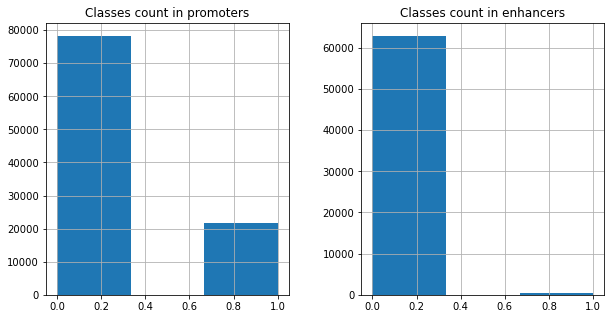

In [9]:
# class balance

import seaborn as sbn

_, axes = plt.subplots(ncols=2, figsize=(10, 5))

for axis, (region, y) in zip(axes.ravel(), labels.items()):
    y.hist(ax=axis, bins=3)
    axis.set_title(f"Classes count in {region}")

#for axis, (region, y) in zip(axes.ravel(), labels.items()):
    #sbn.histplot(data=y, x=cell_line, bins=bins, ax=axis)
    #axis.set_title(f"Class distribution in {region}")

In [12]:
from sklearn.feature_selection import VarianceThreshold

def drop_constant_features(X: pd.DataFrame) -> (pd.DataFrame, bool):
    """Return a DataFrame without constant features in in.

    Parameters
    ----------------
    X: pd.DataFrame
        The dataframe to process.

    Returns
    ----------------
    A tuple with the new DataFrame and a boolean value to point out if the
    new DataFrame is distinct from the input one.
    """
    constant_feature_selector = VarianceThreshold()
    new_X = constant_feature_selector.fit_transform(X)
    return (new_X, new_X.shape[1] != X.shape[1])

In [ ]:
for region, X in epigenomes.items():
    X_new, ok = drop_constant_features(X)
    if ok:
        epigenomes[region] = X_new
    else:
        print(f"{region} doesn't have costant features.")

In [10]:
def impute_with_median(X: pd.DataFrame) -> pd.DataFrame:
    return X.fillna(X.median())

In [ ]:
for region, X in epigenomes.items():
   epigenomes[region] = impute_with_median(X) 

In [11]:
from sklearn.preprocessing import RobustScaler

def robust_scaler(X: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame(
        RobustScaler().fit_transform(X.values),
        columns=X.columns,
        index=X.index
    )

In [ ]:
for region, X in epigenomes.items():
   epigenomes[region] = robust_scaler(X) 

# Verify output correlation

In [ ]:
from scipy.stats import pearsonr

uncorrelated_features_with_output = {
    region: set()
    for region in epigenomes
}

for region, X in epigenomes.items():
    print("="*20, region.upper(), "="*20)
    for feature in tqdm(
        X.columns,
        desc=f"Running Person test for {region}",
        dynamic_ncols = True,
        leave = False
    ):
        correlation, p_value = pearsonr(
            X[feature].values.ravel(),
            labels[region].values.ravel()
        )
        if p_value > 0.01:
            print(f"Feature {feature} has no correlation with the output.")
            uncorrelated_features_with_output[region].add(feature)

print(uncorrelated_features_with_output)

In [ ]:
from scipy.stats import spearmanr

for region, X in epigenomes.items():
    print("="*20, region.upper(), "="*20)
    for feature in tqdm(
        X.columns,
        desc= f"Running Spearman test for {region}",
        dynamic_ncols = True,
        leave = False
    ):
        correlation, p_value = spearmanr(
            X[feature].values.ravel(),
            labels[region].values.ravel()
        )
        if p_value > 0.01:
            print(f"Feature {feature} has no correlation with the output {correlation}.")
            uncorrelated_features_with_output[region].add(feature)

print(uncorrelated_features_with_output)

In [ ]:
from minepy import MINE

for region, X in epigenomes.items():
    for feature in tqdm(
        uncorrelated_features_with_output[region],
        desc = f"Running MINE test for {region}",
        dynamic_ncols = True,
        leave = False
    ):
        mine = MINE()
        mine.compute_score(
            X[feature].values.ravel(),
            labels[region].values.ravel()
        )
        score = mine.mic()
        if score >= 0.05:
            uncorrelated_features_with_output[region].remove(feature)
        else:
            print(region, feature, score)

print(uncorrelated_features_with_output)

In [ ]:
for region, X in epigenomes.items():
    epigenomes[region] = X.drop(columns=[
        c
        for c in uncorrelated_features_with_output[region]
        if c in X.columns                     
    ])

In [ ]:
for _, X in epigenomes.items():
    print(X.shape)

# Feature Correlation

In [ ]:
from scipy.stats import entropy
from typing import List

def features_correlation(
    X: pd.DataFrame,
    p_value_threshold: float = 0.01,
    correlation_threshold: float = 0.95
) -> List:
    scores = []

    for i, feature_1 in tqdm(
        enumerate(X.columns),
        total = len(X.columns),
        desc = f"Running tests for {region}",
        dynamic_ncols = True,
        leave = False
    ):
        for feature_2 in X.columns[i+1:]:
            correlation, p_value = pearsonr(
                X[feature_1].values.ravel(),
                X[feature_2].values.ravel()
            )
            scores.append((correlation, feature_1, feature_2))
    #        if p_value < p_value_threshold and np.abs(correlation) > correlation_threshold:
    #            print(f"High correlation (Pearson): {feature_1} with {feature_2} ({correlation})")
    #            if entropy(X[feature_1]) > entropy(X[feature_2]):
    #                high_correlation[region].add(feature_2)
    #            else:
    #                high_correlation[region].add(feature_1)
    
    return scores

In [ ]:
result = {}

for region, X in epigenomes.items():
    result[region] = features_correlation(X, region)

In [ ]:
scores = {
    region: sorted(score, 
                   key=lambda x: np.abs(x[0]), 
                   reverse=True)
    for region, score in result.items()
}

In [ ]:
for region, X in epigenomes.items():
    # take the first three elems, unwrap them and then merge togheter
    _, firsts, seconds = list(zip(*scores[region][:3]))
    columns = list(set(firsts+seconds))
    print(f"Most correlated features from {region} epigenomes")
    sbn.pairplot(pd.concat([
        X[columns],
        labels[region],
    ], axis=1), hue=labels[region].columns[0])
    plt.show()

In [ ]:
%config Completer.use_jedi = True

In [ ]:
# feature selection via SelectFromModel and TreeModel

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

for region, X in epigenomes.items():
    print(f"Feature selection for {region}")
    clf = ExtraTreesClassifier(
        n_estimators=50,
        max_depth=10
    )
    clf.fit(X, labels[region].values.ravel())
    model = SelectFromModel(clf, prefit=True)
    X_new = pd.DataFrame(
        model.transform(X),
        columns=X.columns[model.get_support()],
        index=X.index
    )
    print(f"new shape: {X_new.shape}")
    epigenomes[region] = X_new

In [ ]:
from sklearn.decomposition import PCA

def pca_decomposition(
    X: pd.DataFrame,
    components: int = 2
) -> pd.DataFrame:
    return pd.DataFrame(
        PCA(n_components=components).fit_transform(X.values),
        index=X.index,
        columns=X.columns,
    )

In [ ]:
def scatter_with_heatmap(
    decomposition: pd.DataFrame,
    scores: np.ndarray,
    figure: Figure,
    ax: Axes
):
    scatter = ax.scatter(
        *decomposition.values.T,
        c=scores,
        cmap=plt.cm.get_cmap('RdYlBu'),
        norm=LogNorm(),
        s=3
    )
    color_bar = figure.colorbar(scatter, ax=ax)

epigenomic_fig, epigenomic_axes = plt.subplots(
    nrows=2,
    figsize=(40, 80),
    squeeze=False
)

for k, metric in enumerate(tqdm(("max", "mean"), desc="Metrics", leave=False)):
    for j, ((epigenomic, scores), region, clip_value) in enumerate(tqdm((
        (active_promoters_vs_inactive_promoters(cell_line=cell_line, metric=metric), "Promoters", 1000),
        (active_enhancers_vs_inactive_enhancers(cell_line=cell_line, metric=metric), "Enhancers", 20)
    ), desc="Task", leave=False)):
        # imputation and scaling of the data
        imputed_epigenomic = pd.DataFrame(
            RobustScaler().fit_transform(
                KNNImputer().fit_transform(epigenomic)
            ),
            columns=epigenomic.columns,
            index=epigenomic.index
        )
        decomposed_epigenomic = pca_decomposition(
            imputed_epigenomic
        ).transform(imputed_epigenomic)
        scores[scores>clip_value] = clip_value
        scatter_with_heatmap(
            decomposition=decomposed_epigenomic,
            scores=scores.values,
            figure=epigenomic_fig,
            ax=k
        )
        

epigenomic_fig.tight_layout()
plt.show()

new_train = {}

for region, X in epigenomes.items():
    p = pca(X, 5)
    print(f"PCA for {region}")
    print(sum(p.explained_variance_ratio_))
    new_train[region] = pd.DataFrame(
        p.transform(X.values),
        index=X.index
    )

In [24]:
from typing import Tuple
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, ReLU, Concatenate, Layer
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalAveragePooling1D, GlobalMaxPool1D, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from extra_keras_metrics import get_complete_binary_metrics

In [ ]:
def build_binary_classification_ffnn(
    input_shape: int
)->Tuple[Model, Layer, Layer]:
    """Returns Feed-Forward Neural Network model for binary classification.
    
    Parameters
    -----------------------
    input_shape: int,
        Number of features in the input layer.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    input_epigenomic_data = Input(shape=(input_shape,), name="epigenomic_data")
    hidden = Dense(64, activation="relu")(input_epigenomic_data)

    for _ in range(2):
        hidden = Dense(
            32,
            activation="relu",
        )(hidden)
        hidden = Dropout(rate=0.3)(hidden)

    last_hidden_ffnn = hidden
    output_ffnn = Dense(1, activation="sigmoid")(input_epigenomic_data)

    ffnn = Model(
        inputs=input_epigenomic_data,
        outputs=output_ffnn,
        name="BinaryClassificationFFNN"
    )

    ffnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )
    return ffnn, input_epigenomic_data, last_hidden_ffnn

In [ ]:
from keras_mixed_sequence import MixedSequence, VectorSequence

def get_ffnn_sequence(
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 1024
) -> MixedSequence:
    """Returns sequence to train a FFNN model on epigenomic data.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a FFNN.
    """
    return MixedSequence(
        x={
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

@Cache(
    cache_path=[
        "model_histories/{cell_line}/{task}/{model_name}/history_{_hash}.csv.xz",
        "model_performance/{cell_line}/{task}/{model_name}/performance_{_hash}.csv.xz",
    ],
    args_to_ignore=[
        "model", "training_sequence", "test_sequence"
    ]
)
def train_model(
    model: Model,
    model_name: str,
    task: str,
    cell_line: str,
    training_sequence: MixedSequence,
    test_sequence: MixedSequence,
    holdout_number: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Returns training history and model evaluations.
    
    Parameters
    ---------------------
    model: Model,
        The model to train.
    model_name: str,
        The model name.
    task: str,
        The name of the task.
    cell_line: str,
        Name of the considered cell line.
    training_sequence: MixedSequence,
        The training sequence.
    test_sequence: MixedSequence,
        The test sequence.
    holdout_number: int,
        The number of the current holdout.
        
    Returns
    ----------------------
    Tuple with training history dataframe and model evaluations dataframe.
    """
    history = pd.DataFrame(model.fit(
        train_sequence,
        validation_data=test_sequence,
        epochs=1000,
        verbose=False,
        callbacks=[
            EarlyStopping(
                "loss",
                min_delta=0.001,
                patience=2,
                mode="min"
            ),
            # I have commented this because we do not need this loading bar
            # when running the main experiment loop. When you experiment with
            # the model structure you may want to enable this to get a feel
            # of how the model is performing during the training.
            TqdmCallback(verbose=1)
        ]
    ).history)
    
    train_evaluation = dict(zip(model.metrics_names, model.evaluate(train_sequence, verbose=False)))
    test_evaluation = dict(zip(model.metrics_names, model.evaluate(test_sequence, verbose=False)))
    train_evaluation["run_type"] = "train"
    test_evaluation["run_type"] = "test"
    
    for evaluation in (train_evaluation, test_evaluation):
        evaluation["model_name"] = model_name
        evaluation["task"] = task
        evaluation["holdout_number"] = holdout_number
    
    evaluations = pd.DataFrame([
        train_evaluation,
        test_evaluation
    ])
    
    return history, evaluations

In [ ]:
for region, X in epigenomes.items():
    y = labels[region]
    for holdout_number, (train_indices, test_indices) in tqdm(
        enumerate(stratified_split.split(X, y)),
        total=n_splits,
        leave=False,
        desc="Computing holdouts"
    ):
        train_X, test_X = X.iloc[train_indices], X.iloc[test_indices]
        train_y, test_y = y.iloc[train_indices], y.iloc[test_indices]
        train_y = train_y.values.flatten()
        test_y = test_y.values.flatten()
        
        ffnn, input_epigenomic_data, last_hidden_ffnn = build_binary_classification_ffnn(X.shape[1])
        
        train_X_seq = get_ffnn_sequence(train_X, train_y)
        test_X_seq = get_ffnn_sequence(test_X, test_y)
        
        history, performance = train_model(
                ffnn,
                ffnn.name,
                region,
                cell_line,
                train_sequence,
                test_sequence,
                holdout_number
        )

Computing holdouts:   0%|          | 0/10 [00:00<?, ?it/s]

Model: "BinaryClassificationFFNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
promoters_ffnn (InputLayer)  [(None, 429)]             0         
_________________________________________________________________
dense_37 (Dense)             (None, 64)                27520     
_________________________________________________________________
dense_38 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_18 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_19 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)    

AttributeError: module 'pandas' has no attribute 'grid'

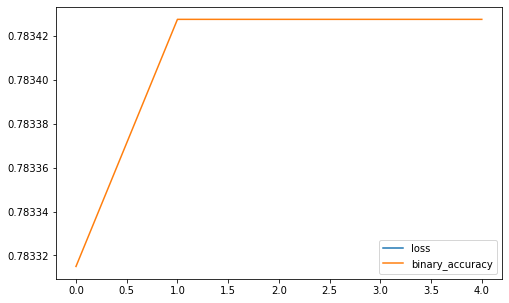

In [28]:
for region, X in epigenomes.items():
    y = labels[region]
    for holdout_number, (train_indices, test_indices) in tqdm(
        enumerate(stratified_split.split(X, y)),
        total=n_splits,
        leave=False,
        desc="Computing holdouts"
    ):
        train_X, test_X = X.iloc[train_indices], X.iloc[test_indices]
        train_y, test_y = y.iloc[train_indices], y.iloc[test_indices]
        train_y = train_y.values.flatten()
        test_y = test_y.values.flatten()


        input_epigenomic_data = Input(shape=train_X.shape[1:], name="promoters_ffnn")
        hidden = Dense(64, activation="relu")(input_epigenomic_data)

        for _ in range(2):
            hidden = Dense(
                32,
                activation="relu",
            )(hidden)
            hidden = Dropout(rate=0.3)(hidden)

        last_hidden_ffnn = hidden
        output_ffnn = Dense(1, activation="sigmoid")(last_hidden_ffnn)

        ffnn = Model(
            inputs=input_epigenomic_data,
            outputs=output_ffnn,
            name="BinaryClassificationFFNN"
        )

        ffnn.compile(
            optimizer="nadam",
            loss="binary_crossentropy",
            metrics=["binary_accuracy"]
        )
        
        print(ffnn.summary())
        
        history = ffnn.fit(
            train_X, train_y,
            epochs=50,
            callbacks=[EarlyStopping(monitor="binary_accuracy", patience=3)]
        )
        pd.DataFrame(history.history).plot(figsize=(8, 5))
        pd.grid(True)
        pd.show()
        break